### Import Dataset

In [ ]:
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", DATASET_PATH)

Resuming download from 140509184 bytes (501059608 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?dataset_version_number=1 (140509184/641568792) bytes left.


100%|██████████| 612M/612M [00:22<00:00, 22.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


### Import Library

In [ ]:
!pip install datasets --quiet
!pip install evaluate --quiet
!pip install huggingface_hub --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import wandb
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from evaluate import load
from datasets import Dataset
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from google.colab import userdata
from huggingface_hub import login
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from transformers import ViTFeatureExtractor, TrainingArguments, ViTForImageClassification, Trainer, EarlyStoppingCallback

### Init WanDB

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
wandb.init(
    project="Traffic Sign Classification",
    name="VIT_Experiment",
    config={
        "model": "VIT",
    }
)

login(token=userdata.get('HUGGING_FACE_TOKEN'))

### Traffic Sign Label Definitions

In [ ]:
CLASS_LABELS = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing veh over 3.5 tons',
    11: 'Right-of-way at intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Veh > 3.5 tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve left',
    20: 'Dangerous curve right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End speed + passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End no passing veh > 3.5 tons'
}

### Load Data

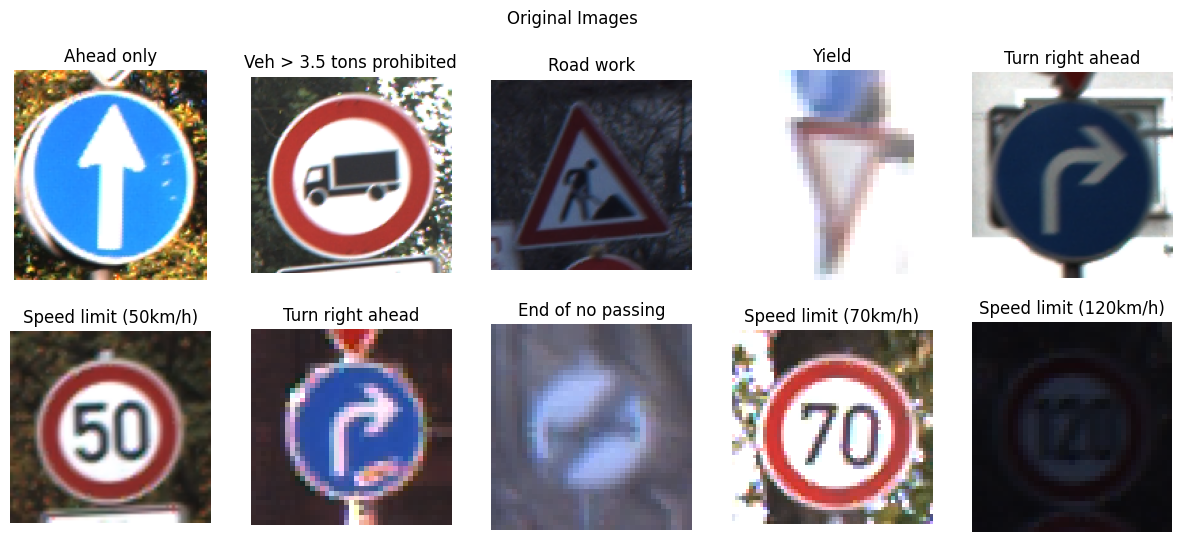

In [ ]:
def _load_images_and_labels(csv_file):
  images, labels = [], csv_file['ClassId'].values
  for path in csv_file['Path']:
      img = cv2.imread(os.path.join(DATASET_PATH, path))
      images.append(img)
  return images, labels

def load_data():
  train_csv = pd.read_csv(os.path.join(DATASET_PATH, "Train.csv"))
  test_csv = pd.read_csv(os.path.join(DATASET_PATH, "Test.csv"))
  meta_csv = pd.read_csv(os.path.join(DATASET_PATH, "Meta.csv"))

  train_images, train_labels = _load_images_and_labels(train_csv)
  test_images, test_labels = _load_images_and_labels(test_csv)
  meta_images, meta_labels = _load_images_and_labels(meta_csv)

  # Combine meta images into the training data
  train_images.extend(meta_images)
  train_labels = np.concatenate((train_labels, meta_labels), axis=0)

  # Shuffle the training and testing datasets to randomize them
  train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
  test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

  # Plotting
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  for i, ax in enumerate(axes.flat):
      ax.imshow(cv2.cvtColor(train_images[i], cv2.COLOR_BGR2RGB))
      ax.set_title(f'{CLASS_LABELS[train_labels[i]]}')
      ax.axis('off')
  plt.suptitle('Original Images')
  plt.show()

  return (train_images, train_labels), (test_images, test_labels)

(train_images, train_labels), (test_images, test_labels) = load_data()

In [ ]:
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

In [ ]:
def create_hf_dataset(images, labels):
    images = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in images] # Convert images from numpy arrays to PIL Image if they are numpy arrays
    data = [{"img": img, "label": label} for img, label in zip(images, labels)] # Create a list of dictionaries containing image and label pairs
    return Dataset.from_list(data) # Create and return a Hugging Face Dataset from the list of dictionaries

train_dataset = create_hf_dataset(train_images, train_labels)
val_dataset = create_hf_dataset(val_images, val_labels)
test_dataset = create_hf_dataset(test_images, test_labels)

total_len = len(train_dataset) + len(val_dataset) + len(test_dataset)

print(f"Train dataset: {len(train_dataset)} ({(len(train_dataset) / total_len) * 100:.2f}%)")
print(f"Validation dataset: {len(val_dataset)} ({(len(val_dataset) / total_len) * 100:.2f}%)")
print(f"Test dataset: {len(test_dataset)} ({(len(test_dataset) / total_len) * 100:.2f}%)")

Train dataset: 39252 (75.66%)
Validation dataset: 6315 (12.17%)
Test dataset: 6315 (12.17%)


### Preprocessing Data

In [ ]:
# Load the pre-trained ViT feature extractor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)
feature_extractor.save_pretrained("./vit-traffic-sign-GTSRB-extractor")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


['./vit-traffic-sign-GTSRB-extractor/preprocessor_config.json']

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
def preprocess_dataset(batch):
    inputs = feature_extractor(
        batch['img'],
        return_tensors='pt'
    )
    inputs['label'] = batch['label']
    return inputs

# Preprocess Dataset
prepared_train = train_dataset.with_transform(preprocess_dataset)
prepared_val = val_dataset.with_transform(preprocess_dataset)
prepared_test = test_dataset.with_transform(preprocess_dataset)

### Build and Train Model

In [ ]:
# Stack pixel values into a tensor and create a tensor for labels
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = load("accuracy")
# Compute accuracy by comparing predicted and actual labels
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )

# Set training arguments
training_args = TrainingArguments(
    output_dir="./vit-traffic-sign-GTSRB",
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=20,
    save_steps=500,
    eval_steps=500,
    logging_steps=50,
    learning_rate=2e-4,
    save_total_limit=3,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Load a pre-trained Vision Transformer model
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(CLASS_LABELS),
    id2label={i: CLASS_LABELS[i] for i in range(len(CLASS_LABELS))},
    label2id={CLASS_LABELS[i]: i for i in range(len(CLASS_LABELS))}
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_val,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

<ipython-input-18-543a8b191899>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train model
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy
500,0.097200,0.130720,0.972288
1000,0.149700,0.153679,0.963579
1500,0.095100,0.134548,0.969755
2000,0.203600,0.099144,0.974347
2500,0.056900,0.095750,0.978464
3000,0.019200,0.059285,0.983848
3500,0.029700,0.096141,0.979731
4000,0.042300,0.184419,0.960253
4500,0.059500,0.131639,0.972922


***** train metrics *****
  epoch                    =       1.8337
  total_flos               = 5197285932GF
  train_loss               =       0.1591
  train_runtime            =   0:16:55.25
  train_samples_per_second =      773.243
  train_steps_per_second   =       48.342


### Evaluate The Model Using Test Data

In [ ]:
metrics = trainer.evaluate(prepared_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =     1.8337
  eval_accuracy           =     0.9846
  eval_loss               =     0.0643
  eval_runtime            = 0:00:31.42
  eval_samples_per_second =    200.926
  eval_steps_per_second   =     25.136


In [ ]:
predictions = trainer.predict(prepared_test)

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

classification_metrics = {
  'accuracy': accuracy_score(y_true, y_pred),
  'precision': precision_score(y_true, y_pred, average='weighted'),
  'recall': recall_score(y_true, y_pred, average='weighted'),
  'f1_score': f1_score(y_true, y_pred, average='weighted')
}

In [ ]:
print(f"💡Test Loss: {metrics['eval_loss']}")
print(f"💡Test Accuracy: {metrics['eval_accuracy']}")

💡Test Loss: 0.06433115899562836
💡Test Accuracy: 0.9846397466349961


In [ ]:
print("💡 Classification Metrics:")
for metric, value in classification_metrics.items():
  print(f"{metric}: {value}")

💡 Classification Metrics:
accuracy: 0.9846397466349961
precision: 0.985273841160585
recall: 0.9846397466349961
f1_score: 0.9846072877146136


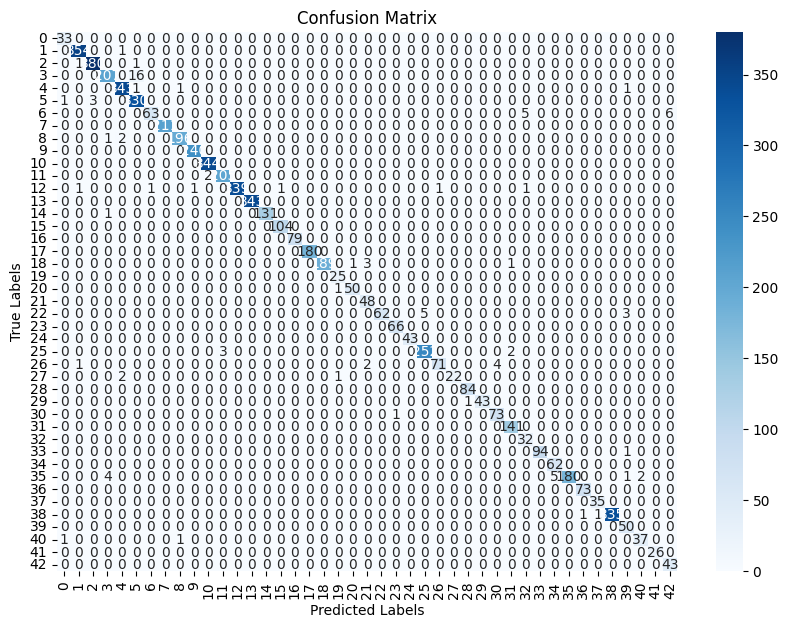

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

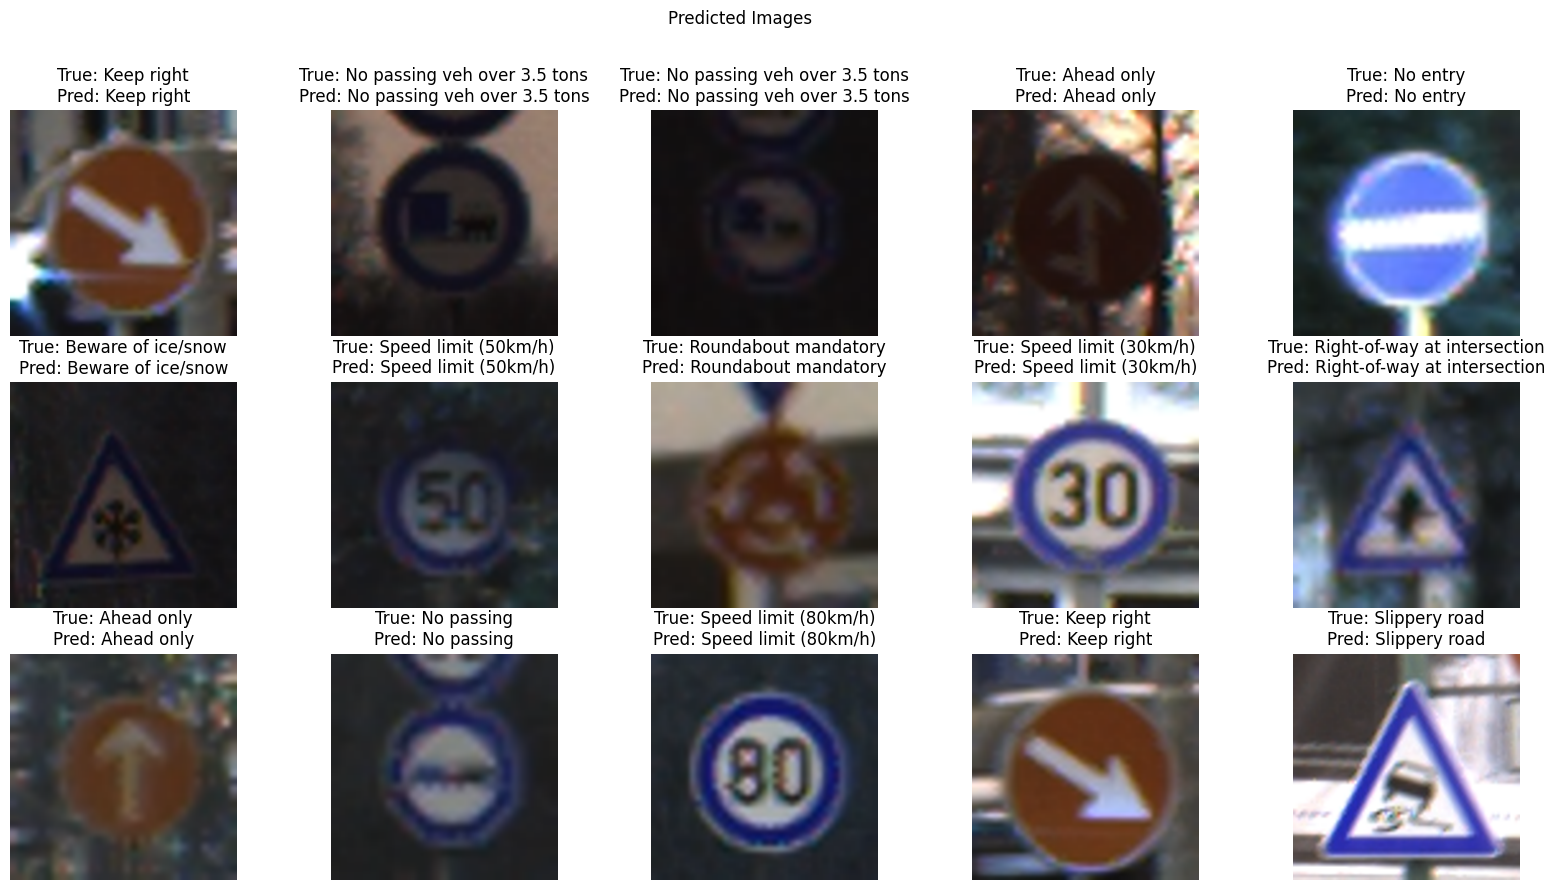

In [ ]:
X_test_visual = np.array([test_dataset[i]['img'].convert('RGB').resize((224, 224)) for i in range(15)])
y_true = np.array(test_labels)
y_pred = np.argmax(predictions.predictions, axis=1)

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_visual[i])
    ax.set_title(f"True: {CLASS_LABELS[y_true[i]]}\nPred: {CLASS_LABELS[y_pred[i]]}")
    ax.axis('off')

plt.suptitle('Predicted Images')
plt.show()


### Analysis of Missclassification

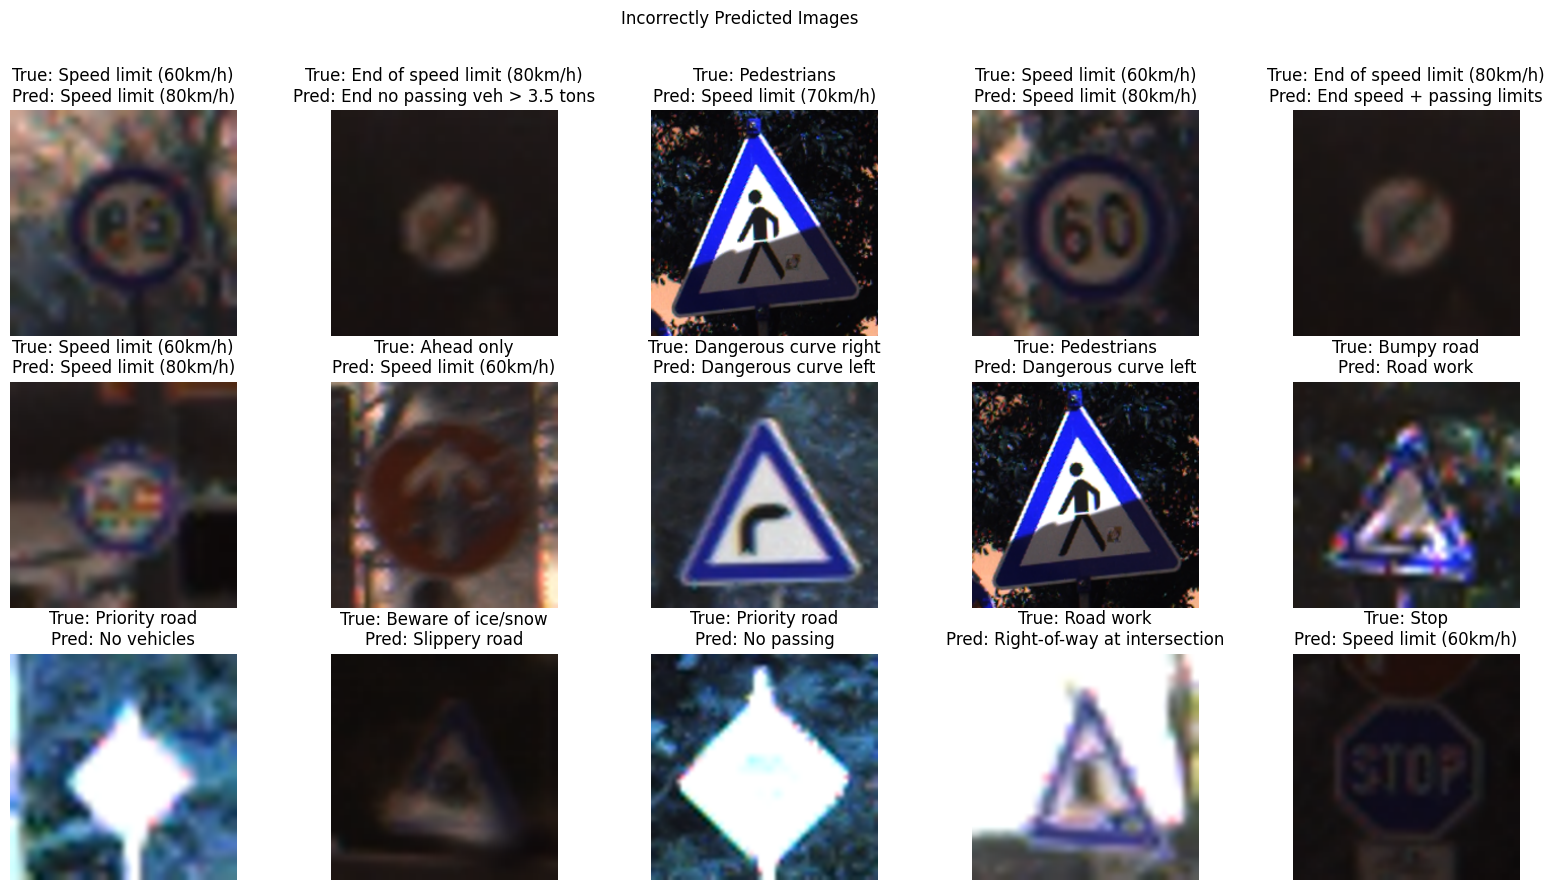

In [ ]:
incorrect_predictions = np.where(y_pred != y_true)[0]

X_test_visual_incorrect = np.array([test_dataset[int(i)]['img'].convert('RGB').resize((224, 224)) for i in incorrect_predictions])
y_true_incorrect = y_true[incorrect_predictions]
y_pred_incorrect = y_pred[incorrect_predictions]

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    if i < len(incorrect_predictions):
        ax.imshow(X_test_visual_incorrect[i])
        ax.set_title(f"True: {CLASS_LABELS[y_true_incorrect[i]]}\nPred: {CLASS_LABELS[y_pred_incorrect[i]]}")
    ax.axis('off')

plt.suptitle('Incorrectly Predicted Images')
plt.show()

In [ ]:
misclassifications = list(zip(y_true_incorrect, y_pred_incorrect))
misclass_counts = Counter(misclassifications)

top_misclassifications = misclass_counts.most_common(10)

print("💡Top 10 Misclassifications:")
for (true_label, pred_label), count in top_misclassifications:
    print(f"True: {CLASS_LABELS[true_label]}, Pred: {CLASS_LABELS[pred_label]}: {count} times")

💡Top 10 Misclassifications:
True: Speed limit (60km/h), Pred: Speed limit (80km/h): 16 times
True: End of speed limit (80km/h), Pred: End no passing veh > 3.5 tons: 6 times
True: End of speed limit (80km/h), Pred: End speed + passing limits: 5 times
True: Bumpy road, Pred: Road work: 5 times
True: Ahead only, Pred: Turn left ahead: 5 times
True: Ahead only, Pred: Speed limit (60km/h): 4 times
True: Traffic signals, Pred: Beware of ice/snow: 4 times
True: Road work, Pred: Right-of-way at intersection: 3 times
True: Speed limit (80km/h), Pred: Speed limit (50km/h): 3 times
True: Bumpy road, Pred: Keep left: 3 times


In [ ]:
def get_attention_map(img, model, feature_extractor, get_mask=False):
    model = model.to(device)

    with torch.no_grad():
        inputs = feature_extractor(images=img, return_tensors="pt").to(device)

        outputs = model(**inputs, output_attentions=True)
        logits = outputs.logits
        att_mat = torch.stack(outputs.attentions).squeeze(1)

        # Average the attention weights across all heads
        att_mat = torch.mean(att_mat, dim=1)

        # Add an identity matrix to the attention matrix for residual connections and normalize
        residual_att = torch.eye(att_mat.size(1)).to(device)
        aug_att_mat = att_mat + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

        # Recursively multiply the weight matrices to get joint attention
        joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
        joint_attentions[0] = aug_att_mat[0]

        # For each subsequent attention layer, multiply the current attention matrix with the previous one
        for n in range(1, aug_att_mat.size(0)):
            joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

        # Get the final attention map (after all layers)
        v = joint_attentions[-1]
        grid_size = int(np.sqrt(aug_att_mat.size(-1)))

        # Reshape the attention values into a 2D mask
        mask = v[0, 1:].reshape(grid_size, grid_size).detach().cpu().numpy()

        if get_mask:
            result = cv2.resize(mask / mask.max(), (img.size[0], img.size[1]))
        else:
            mask_resized = cv2.resize(mask / mask.max(), (img.size[0], img.size[1]))[..., np.newaxis]
            result = (mask_resized * np.array(img)).astype("uint8")

    return result

def plot_attention_maps(test_dataset, top1_indices, true_label, pred_label, model, feature_extractor):
    for idx, i in enumerate(top1_indices):
        img = test_dataset[i]['img'].convert('RGB').resize((224, 224))
        att_map_with_mask = get_attention_map(img, model, feature_extractor, get_mask=True)
        att_map_normal = get_attention_map(img, model, feature_extractor, get_mask=False)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f'Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(att_map_with_mask)
        plt.title('Attention Map')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(att_map_normal)
        plt.title('Attention Map')
        plt.axis('off')

        plt.suptitle(f'Misclassification Analysis Using Attention Maps | True: {CLASS_LABELS[true_label]}, Pred: {CLASS_LABELS[pred_label]}')
        plt.show()


In [ ]:
for most_common_misclass in top_misclassifications:
    true_label, pred_label = most_common_misclass[0]
    count = most_common_misclass[1]

    top1_indices = [int(idx) for idx in incorrect_predictions if y_true[idx] == true_label and y_pred[idx] == pred_label]

    if top1_indices:
        plot_attention_maps(test_dataset, [top1_indices[0]], true_label, pred_label, model, feature_extractor)

Output hidden; open in https://colab.research.google.com to view.

### Push Model to HuggingFace and Log Metrics to WanDB

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'GTSRB',
    "tags": ['image-classification', 'traffic-sign-classification', 'GTSRB'],
}

model.push_to_hub(repo_id="kelvinandreas/vit-traffic-sign-GTSRB", **kwargs)
feature_extractor.push_to_hub(repo_id="kelvinandreas/vit-traffic-sign-GTSRB")

README.md:   0%|          | 0.00/5.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kelvinandreas/vit-traffic-sign-GTSRB/commit/897240850d7e2650ef2dc412e77e0766785afb9d', commit_message='Upload feature extractor', commit_description='', oid='897240850d7e2650ef2dc412e77e0766785afb9d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kelvinandreas/vit-traffic-sign-GTSRB', endpoint='https://huggingface.co', repo_type='model', repo_id='kelvinandreas/vit-traffic-sign-GTSRB'), pr_revision=None, pr_num=None)

In [ ]:
wandb.log({
    'test_loss': metrics["eval_loss"],
    'test_accuracy': metrics["eval_accuracy"],
    'accuracy': classification_metrics['accuracy'],
    'precision': classification_metrics['precision'],
    'recall': classification_metrics['recall'],
    'f1_score': classification_metrics['f1_score']
})
wandb.finish()

accuracy,▁
eval/accuracy,▄▂▄▅▆█▇▁▅█
eval/loss,▅▆▅▃▃▁▃█▅▁
eval/runtime,▆▃█▃▃▅▃▁▄▆
eval/samples_per_second,▃▆▁▆▆▄▆█▅▃
eval/steps_per_second,▃▆▁▆▆▄▆█▅▃
f1_score,▁
precision,▁
recall,▁
test/accuracy,▁
test/loss,▁
